In [20]:
import pandas as pd
import sys
import os
from dotenv import load_dotenv
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from textstat.textstat import *
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS 
import numpy as np

In [2]:
load_dotenv()

# Agregar el directorio raíz al PYTHONPATH
sys.path.append(os.getenv("PYTHONPATH"))
print("PYTHONPATH:", os.getenv("PYTHONPATH"))

from src.hate_speach.utils.constants import HATE_SPEACH_PATH

stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

PYTHONPATH: C:\\Users\\Usuario\\Documents\\tesis-fake-news
HATE_SPEACH_PATH cargado correctamente: C:\\Users\\Usuario\\Documents\\tesis-fake-news\\data\\hate_speach\\raw\\dataset.csv


In [3]:
data = pd.read_csv(HATE_SPEACH_PATH)
data['text length'] = data['tweet'].apply(len)
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


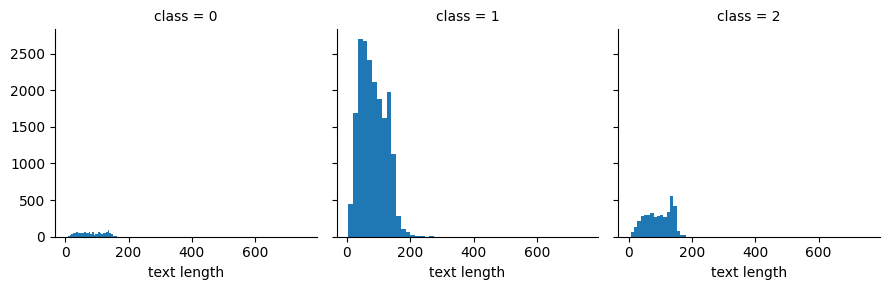

In [4]:
graph = sns.FacetGrid(data=data, col='class')
graph.map(plt.hist, 'text length', bins=50)

In [5]:
data_cleanning = data['tweet'].str.replace(r'\s+', ' ', regex=True)
#Eliminar menciones a usuarios
data_cleanning = data_cleanning.str.replace(r'@[\w\-]+', '', regex=True)
#Eliminar URLs
data_cleanning =  data_cleanning.str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex=True)

#Eliminar caracteres especiales y números
data_cleanning = data_cleanning.str.replace(r'[^a-zA-Z\s]', '', regex=True)

#Eliminar multiples espacios
data_cleanning = data_cleanning.str.replace(r'\s+', ' ', regex=True)

#Eliminar espacios al inicio y al final
data_cleanning = data_cleanning.str.replace(r'^\s+|\s+?$', '', regex=True)

#Remplazar numeros por la palabra numbr
data_cleanning = data_cleanning.str.replace(r'\d+(\.\d+)?', 'numbr', regex=True)
#Convertir a minusculas
data_cleanning = data_cleanning.str.lower()

#Tokenizar el texto
data_cleanning = data_cleanning.apply(lambda x: x.split())

#Eliminar stopwords
data_cleanning = data_cleanning.apply(lambda x: [item for item in x if item not in stopwords])

#Stemming del texto
data_cleanning = data_cleanning.apply(lambda x: [stemmer.stem(i) for i in x])

#Unir el texto
data_cleanning = data_cleanning.apply(lambda x: ' '.join(x))

data['processed_data'] = data_cleanning
print(data.head())

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  \
0  !!! RT @mayasolovely: As a woman you shouldn't...          140   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137   

                                      processed_data  
0  woman shouldnt complain clean hous amp man alw...  
1   boy dat coldtyga dwn bad cuffin 

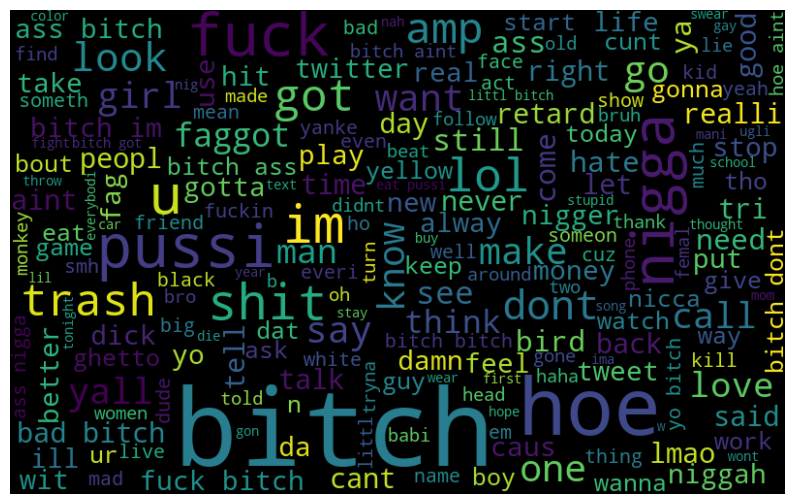

In [6]:
from wordcloud import WordCloud
      
all_words = ' '.join([text for text in data['processed_data'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
        #random=0.30
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Prueba de entramiento con una caracteristicas y varios modelos

In [7]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(data['processed_data'] )
tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 198141 stored elements and shape (24783, 6646)>

In [8]:
X = tfidf
print("Modelo de regresión logística")
y = data['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)



Modelo de regresión logística
Accuracy:  0.8928787573128909
Precision:  0.8780485085131734
Recall:  0.8928787573128909
F1:  0.8794377668489555


In [9]:
X = tfidf
print("Modelo de Ramdom Forest")
y = data['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1).fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)


Modelo de Ramdom Forest
Accuracy:  0.8963082509582408
Precision:  0.8798348904103109
Recall:  0.8963082509582408
F1:  0.8817992417784677


In [11]:
x = tfidf
print("Modelo de SVM")
y = data['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
from sklearn.svm import SVC
model = SVC().fit(X_train_tfidf,y_train)
y_preds = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Modelo de SVM
Accuracy:  0.8965099858785556
Precision:  0.8812310686532767
Recall:  0.8965099858785556
F1:  0.8811908564373337


## Analisis de Modelos agregando caractertisiticas como analisis de sentimiento

In [12]:
sentiment_analyzer = VS()
def count_tags(tweet_c):  
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', tweet_c)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def sentiment_analysis(tweet):   
    sentiment = sentiment_analyzer.polarity_scores(tweet)    
    twitter_objs = count_tags(tweet)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                twitter_objs[2]]
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(tweets):
    features=[]
    for t in tweets:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(data['tweet'])
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                            'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\('
<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\('
<>:7: SyntaxWarning: invalid escape sequence '\w'
<>:8: SyntaxWarning: invalid escape sequence '\w'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22692\2241934314.py:4: SyntaxWarning: invalid escape sequence '\s'
  space_pattern = '\s+'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22692\2241934314.py:6: SyntaxWarning: invalid escape sequence '\('
  '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22692\2241934314.py:7: SyntaxWarning: invalid escape sequence '\w'
  mention_regex = '@[\w\-]+'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22692\2241934314.py:8: SyntaxWarning: invalid escape sequence '\w'
  hashtag_regex = '#[\w\-]+'


In [13]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(24783, 6653)

In [14]:
X = pd.DataFrame(modelling_features)
y = data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print("Modelo de regresión logística")
model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Modelo de regresión logística
Accuracy:  0.8952995763566673
Precision:  0.8812340654220231
Recall:  0.8952995763566673
F1:  0.8821212878741924


c:\Users\Usuario\Documents\tesis-fake-news\entorno_tesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
X = pd.DataFrame(modelling_features)
y = data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print("Modelo de Ramdom Forest")
model = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)
y_preds = model.predict(X_test)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Modelo de Ramdom Forest
Accuracy:  0.890054468428485
Precision:  0.8743643452523926
Recall:  0.890054468428485
F1:  0.8731697395462039


In [26]:
X = pd.DataFrame(modelling_features)
y = data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print("Modelo de SVM")
model = SVC().fit(X_train,y_train)
y_preds = model.predict(X_test)

acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)


Modelo de SVM
Accuracy:  0.880371192253379
Precision:  0.8597195140367592
Recall:  0.880371192253379
F1:  0.8555183979054822


In [21]:
def additional_features(tweet): 
    
    syllables = textstat.syllable_count(tweet)
    num_chars = sum(len(w) for w in tweet)
    num_chars_total = len(tweet)
    num_words = len(tweet.split())
    # avg_syl = total syllables/ total words
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(tweet.split()))
    
    #  Flesch–Kincaid readability tests are readability tests 
    #  designed to indicate how difficult a passage in English is to understand. 
    # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade 
    # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
    # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    
    ###Modified FK grade, where avg words per sentence is : just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                num_unique_terms]
    return add_features

def get_additonal_feature_array(tweets):
    features=[]
    for t in tweets:
        features.append(additional_features(t))
    return np.array(features)

fFeatures = get_additonal_feature_array(data_cleanning)

In [23]:
tfidf_a = tfidf.toarray()
modelling_features_enhanced = np.concatenate([tfidf_a,final_features,fFeatures],axis=1)
modelling_features_enhanced.shape

(24783, 6661)

In [24]:
X = pd.DataFrame(modelling_features)
y = data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print("Modelo de regresión logística")
model = LogisticRegression().fit(X_train,y_train)
y_preds = model.predict(X_test)
acc = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, average='weighted')  # Cambia el promedio según lo que necesites
recall = recall_score(y_test, y_preds, average='weighted')
f1 = f1_score(y_test, y_preds, average='weighted')

print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)

Modelo de regresión logística
Accuracy:  0.8952995763566673
Precision:  0.8812340654220231
Recall:  0.8952995763566673
F1:  0.8821212878741924


c:\Users\Usuario\Documents\tesis-fake-news\entorno_tesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
